# Data Analytics Tech Challenge - Fase 2 Machine Learning and Data Analytics

## Grupo 41

- [André Guilherme Corrêa](https://www.linkedin.com/in/agcorrea/)
- [Letícia Maia de Oliveira](https://www.linkedin.com/in/lemaia/)
- [Nathalia Souza Vaz](https://www.linkedin.com/in/sousanathalias/)
- [Renan Felipe Silva](https://www.linkedin.com/in/renan-silva-16960313a)

## O Problema

Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados da IBOVESPA (Bolsa de valores) para criar uma série temporal e prever diariamente o fechamento da base.

Para isso utilize a base de dados contida no [site da investing](https://br.investing.com/indices/bovespa-historical-data) e selecione o período “diário”, com o intervalo de tempo que achar adequado.

Você precisará demonstrar para o time de investimentos:

1. O modelo com o storytelling, desde a captura do dado até a entrega do modelo;
2. Justificar a técnica utilizada;
3. Atingir uma acuracidade adequada (acima de 70%).

> DICA: Utilize o maior intervalo de tempo possível para atingir maior acuracidade no modelo preditivo.

## Dicionário de dados

- Data:
- Último: preço do índice no fechamento
- Abertura: preço do índice na abertura do mercado
- Máxima: maior preço durante o dia
- Mínima: menor preço durante o dia
- Vol.: volume de negociações
- Var%: variação do preço entre a abertura e o fechamento

## Captura dos dados

###Importação de bibliotecas

In [1]:
import datetime as datetime
import matplotlib.pyplot as plt
import pandas as pd


### Importação inicial

In [2]:
# Lendo dados da fonte externa para que todos consigam rodar o código no Colab sem ter que fazer upload do arquivo
# Mantendo Dataframe original para facilitar rodar as transformações multiplas vezes
df_raw = pd.read_csv(
    'https://raw.githubusercontent.com/agcorrea/fiap-techchallenge-grupo41/main/fase-2/dados/ibovespa_2003-01-01_2023-03-09.csv',
    parse_dates=['Data'], dayfirst=True,
    thousands='.', decimal=',')
df_raw.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2023-03-09,105071,106540,106724,105053,"19,17M","-1,38%"
1,2023-03-08,106540,104228,106721,104228,"15,90M","2,22%"
2,2023-03-07,104228,104700,105179,103480,"12,58M","-0,45%"
3,2023-03-06,104700,103865,105171,103170,"14,28M","0,80%"
4,2023-03-03,103866,103326,104440,103323,"13,10M","0,52%"


In [3]:
df_raw.dtypes

Data        datetime64[ns]
Último               int64
Abertura             int64
Máxima               int64
Mínima               int64
Vol.                object
Var%                object
dtype: object

As colunas `Data`, `Último`, `Abertura`, `Máxima` e `Mínima` foram corretamente parseadas com os parâmetros do `pd.read_csv`.

Teremos que tratar as colunas `Vol.` e `Var%` para que se tornem númericas.

### Transformações

No arquivo CSV baixado do site investing.com, os valores das colunas `Vol.` e `Var%` estão formatados como texto.



In [4]:
# Explorando quais unidades estão presentes na coluna Vol.
df_raw['Vol.'].str.replace('\d', '', regex=True).unique()

array([',M', ',K', nan], dtype=object)

In [5]:
f"Porcentagem de valores da coluna `Var%` que terminam com %: {len(df_raw[df_raw['Var%'].str.endswith('%')]) / len(df_raw) * 100}%"

'Porcentagem de valores da coluna `Var%` que terminam com %: 100.0%'


O código à seguir transforma as colunas para seus respectivos valores numéricos.

*   `Vol.`: os valores estão representados com os símbolos M e K que significam milhões e milhares, respectivamente.
*   `Var%`: os valores estão representados com o símbolo de porcentagem e separador decimal `,`.



In [6]:
# Função para transformar a coluna `Vol.` de texto para números inteiros
def parse_vol(x):
  # Não faz nada caso não seja uma string
  if type(x) != str:
    return None

  # Multiplica por 1 milhão se possuí símbolo M ou por 1 mil se símbolo K
  multiplier = 1_000_000 if x.endswith('M') else 1_000

  # Remove o símbolo M ou K
  result = x[:-1]

  # Altera o separador para . ao invés de ,
  result = result.replace(',', '.')
  # Transforma a string em número
  result = float(result)

  # Multiplica o número pelo multiplicador e transforma em inteiro
  return int(result * multiplier)

In [7]:
# Função para transformar a coluna `Var%` de texto para número decimal
def parse_var(x):
  # Remove o símbolo de %
  result = x[:-1]

  # Altera o separador para . ao invés de ,
  result = result.replace(',', '.')

  # Transforma a string em número
  result = float(result)

  # Transforma em porcentagem
  return result / 100

In [8]:
# Cria um novo DataFrame a partir dos dados crus para aplicar as transformações
df = df_raw.copy()
df['Vol.'] = df['Vol.'].apply(parse_vol)
df['Var%'] = df['Var%'].apply(parse_var)
df = df.set_index('Data', drop=True)
df = df.sort_index()
df.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2003-01-02,11603,11291,11603,11291,195130000.0,0.0297
2003-01-03,11600,11632,11798,11600,197050000.0,-0.0002
2003-01-06,12020,11636,12032,11633,398400000.0,0.0362
2003-01-07,11876,12010,12018,11842,387980000.0,-0.0119
2003-01-08,11786,11875,11928,11757,217190000.0,-0.0076


In [9]:
df.dtypes

Último        int64
Abertura      int64
Máxima        int64
Mínima        int64
Vol.        float64
Var%        float64
dtype: object

Após as transformações, todos os tipos estão corretos.

### Dados faltantes

Neste bloco, os dados faltantes serão encontrados e tratados caso necessário.

In [10]:
# Quantidade de valores nulos por coluna
df.isnull().sum()

Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

Temos um único valor nulo na coluna `Vol.`.

In [11]:
# Filtra dataframe procurando por valores nulos na coluna Vol.
df[df.isnull()['Vol.'] == True]

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2016-02-10,40377,40592,40592,39960,NaN,-0.0053


Segundo o site [Yahoo! Finance](https://yhoo.it/3P3HaYv), no dia 10/02/2016 ocorreu um volume de movimentações de 3.70M.

![ibovespa_2016-02-10.png](https://raw.githubusercontent.com/agcorrea/fiap-techchallenge-grupo41/main/fase-2/assets/ibovespa_2016-02-10.png)

In [12]:
# Atualiza o valor nulo com o encontrado no Yahoo! Finance
df.loc['2016-02-10', 'Vol.'] = 3.7 * 1_000_000
df[df.index == '2016-02-10']

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2016-02-10,40377,40592,40592,39960,3700000.0,-0.0053


In [13]:
print('Teste de sanidade, nenhum valor deve ser nulo:')

# Quantidade de valores nulos por coluna
df.isnull().sum()

Teste de sanidade, nenhum valor deve ser nulo:


Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        0
Var%        0
dtype: int64

## Análise Exploratória dos Dados

Conforme escopo definido inicialmente para este projeto, a variável target, que iremos realizar a previsão será o preço de fechamento,  portanto a coluna nomeada como ***Último*** de nosso *dataframe*.

####Importação de bibliotecas

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import normaltest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels as sm
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


### Análise estatística

In [15]:
# Entendendo o tamanho da nossa base de dados
df.shape

(5000, 6)

In [16]:
#Analise estatística
df.describe()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
count,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03,5000.000000
mean,62253.400200,62235.375200,62871.646000,61601.993800,4.959029e+07,0.000595
std,28200.997062,28203.446595,28420.936536,27972.454981,1.029088e+08,0.017202
min,9995.000000,10006.000000,10151.000000,9968.000000,1.121000e+05,-0.147800
25%,45481.500000,45474.000000,45973.500000,45005.250000,2.830000e+06,-0.008500
50%,58080.000000,58072.500000,58617.000000,57524.000000,4.480000e+06,0.000900
75%,76035.500000,76017.750000,76690.000000,75303.750000,1.473250e+07,0.010125
max,130776.000000,130776.000000,131190.000000,129526.000000,9.949600e+08,0.146600


###Análise de distribuição

#### Histogramas

A nossa variável target, que vamos querer prever, são os ***preços de fechamamento***, ou seja, a coluna *Último*.

Desta forma, O primeiro passo será verificar como nossa varivel target está distribuida.

Para isso iremos plotar um **histograma** da coluna "*Ùltimo*" e realizar um ***teste de hipotese***.



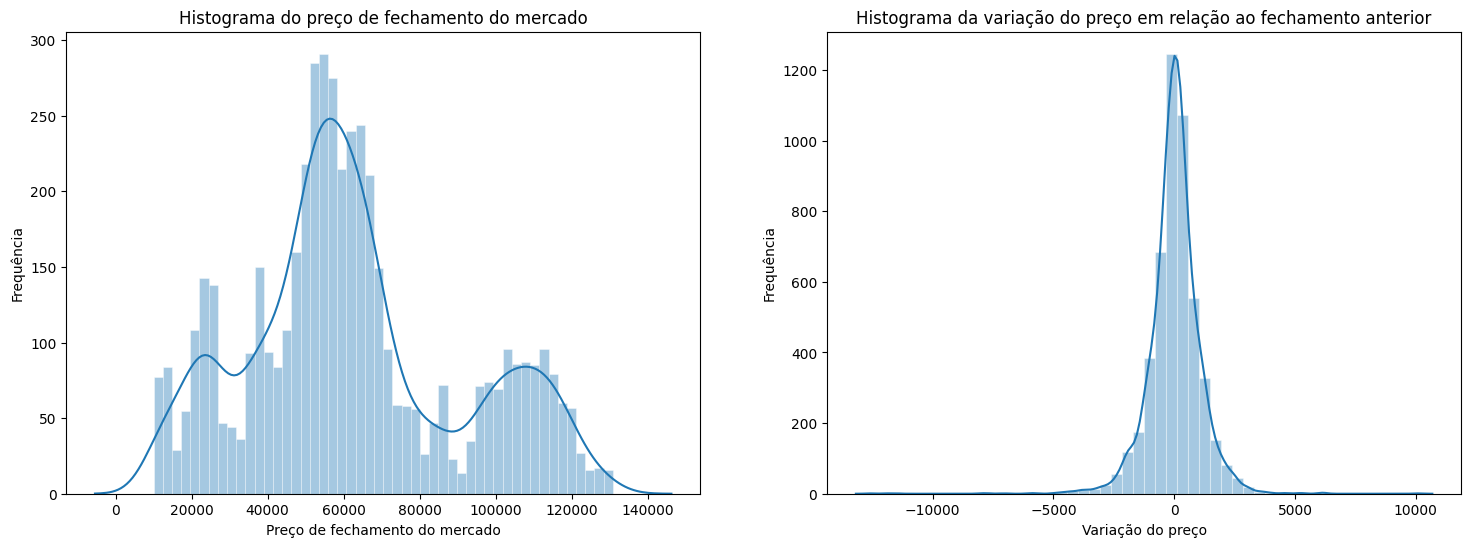

In [17]:
_, axes = plt.subplots(1, 2, figsize=(18,6))

# Histograma do preço de fechamento do mercado
ax = sns.histplot(
    df['Último'],
    ax=axes[0],
    kde=True, kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4),
    bins=50,
)
ax.set_title('Histograma do preço de fechamento do mercado')
ax.set_ylabel('Frequência')
ax.set_xlabel('Preço de fechamento do mercado')

# Histograma da variação do preço de fechamento do mercado
ax = sns.histplot(
    df['Último'].diff(1),
    ax=axes[1],
    kde=True, kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4),
    bins=50,
)
ax.set_title('Histograma da variação do preço em relação ao fechamento anterior')
ax.set_ylabel('Frequência')
ax.set_xlabel('Variação do preço')

plt.show()

#### Teste de normalidade

- Hipótese Nula: os dados seguem distribuição normal
- Hipótese Alternativa: os dados não seguem distribuição normal

Nível de confiança: 95%

In [18]:
alpha = 0.05
k2, p = normaltest(df['Último'])

print('Teste de normalidade sobre o preço do fechamento')
if p < alpha:
    print('A Hipótese Nula pode ser rejeitada, ou seja, Distribuição NÃO é normal')
else:
    print('A hipótese nula não pode ser rejeitada, ou seja, a Distribuição é normal')

Teste de normalidade sobre o preço do fechamento
A Hipótese Nula pode ser rejeitada, ou seja, Distribuição NÃO é normal


In [19]:
alpha = 0.05
k2, p = normaltest(df['Último'].diff(1))

print('Teste de normalidade sobre a variação do preço em relação ao fechamento anterior')
if p < alpha:
    print('A Hipótese Nula pode ser rejeitada, ou seja, Distribuição NÃO é normal')
else:
    print('A hipótese nula não pode ser rejeitada, ou seja, a Distribuição é normal')

Teste de normalidade sobre a variação do preço em relação ao fechamento anterior
A hipótese nula não pode ser rejeitada, ou seja, a Distribuição é normal


####Boxplot

Iremos analisar a distribuição dos dados separados por dois distintos grupos: altas e baixas. O boxplot nos permitirá visualizar a proporção de altas e quedas estão distrubuido de forma proporcional, garantindo que nosso  modelo terá dados suficientes para prever os dois cenários de forma efetiva. O boxplot também é uma excelente ferramenta para identificar outiliers.

In [20]:
#adicionando label 1 para alta e 0 para queda de acordo com a variação

In [21]:
condicoes = [(df['Var%'] < 0),
             (df['Var%'] > 0)]
opcoes = ["0","1"]
df['class_num'] = np.select(condicoes, opcoes)
df

,Último,Abertura,Máxima,Mínima,Vol.,Var%,class_num
Data,,,,,,,
2003-01-02,11603,11291,11603,11291,195130000.0,0.0297,1
2003-01-03,11600,11632,11798,11600,197050000.0,-0.0002,0
2003-01-06,12020,11636,12032,11633,398400000.0,0.0362,1
2003-01-07,11876,12010,12018,11842,387980000.0,-0.0119,0
2003-01-08,11786,11875,11928,11757,217190000.0,-0.0076,0
...,...,...,...,...,...,...,...
2023-03-03,103866,103326,104440,103323,13100000.0,0.0052,1
2023-03-06,104700,103865,105171,103170,14280000.0,0.0080,1
2023-03-07,104228,104700,105179,103480,12580000.0,-0.0045,0


In [22]:
condicoes = [(df['Var%'] < 0),
             (df['Var%'] == 0),
             (df['Var%'] > 0)]
opcoes = ["Baixa","Nulo","Alta"]
df['class_name'] = np.select(condicoes, opcoes)
df

,Último,Abertura,Máxima,Mínima,Vol.,Var%,class_num,class_name
Data,,,,,,,,
2003-01-02,11603,11291,11603,11291,195130000.0,0.0297,1,Alta
2003-01-03,11600,11632,11798,11600,197050000.0,-0.0002,0,Baixa
2003-01-06,12020,11636,12032,11633,398400000.0,0.0362,1,Alta
2003-01-07,11876,12010,12018,11842,387980000.0,-0.0119,0,Baixa
2003-01-08,11786,11875,11928,11757,217190000.0,-0.0076,0,Baixa
...,...,...,...,...,...,...,...,...
2023-03-03,103866,103326,104440,103323,13100000.0,0.0052,1,Alta
2023-03-06,104700,103865,105171,103170,14280000.0,0.0080,1,Alta
2023-03-07,104228,104700,105179,103480,12580000.0,-0.0045,0,Baixa


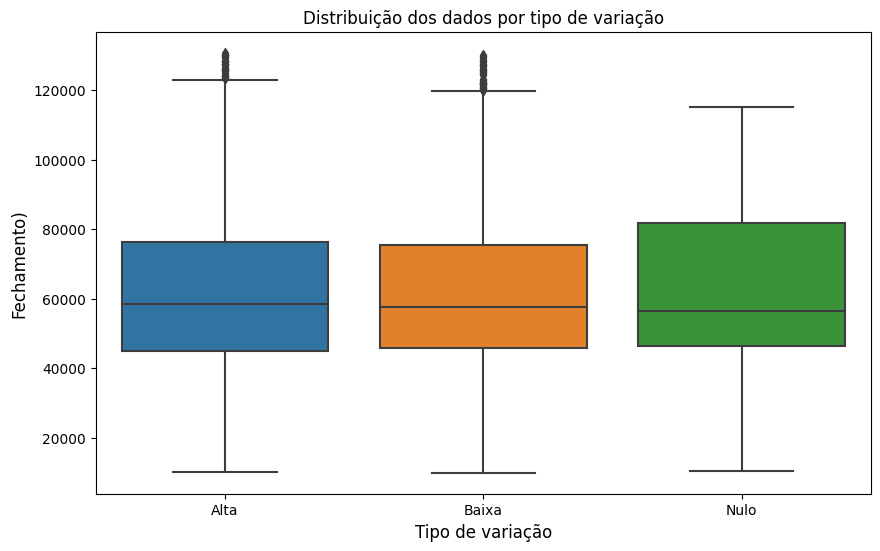

In [23]:
# definindo o tamanho do plot
fig, ax = plt.subplots(figsize = ( 10, 6 ))

# plotando o gráfico
sns.boxplot(x = 'class_name', y = 'Último', data = df)
ax.set_xlabel( "Tipo de variação" , size = 12 )
ax.set_ylabel( "Fechamento)" , size = 12 )

# definindo o título
plt.title("Distribuição dos dados por tipo de variação");

###Analise de Séries temporais

**Séries temporais** são observações registradas ao longo do tempo e que agregam em seu comportamento as seguintes caracteristicas:

*   **Tendencia (Trend)** :  representa a direção geral para onde sua variavel estará evoluindo no decorrer do tempo.

*   **Sazonalidade (Seasonal)**: são oscilações que podem ocorrer de forma recorrente ou se repetirem em um determinado período de tempo específico

*   **Resíduo (Resid)**:  os dados que não foram identificados ou separados da observação original são também chamado de ruídoou residuo.
*   Item da lista

*   **Estacionariedade**:  quando a média, variância e covariância permanecem constante ao longo da dimensão temporal.

> Fonte: https://maxwellpaparelli.medium.com/time-series-s%C3%A9ries-temporais-com-python-f4e74fd45b0b

Assim, como próximos passos para o projeto, a equipe decidiu  analisar a tendência e sazonalidade da nossa série, bem como iremos identificar se nossa série é estacionária ou não.




####Visualização da série temporal

Plotar a série temporal para analisar o comportamento ao longo do tempo


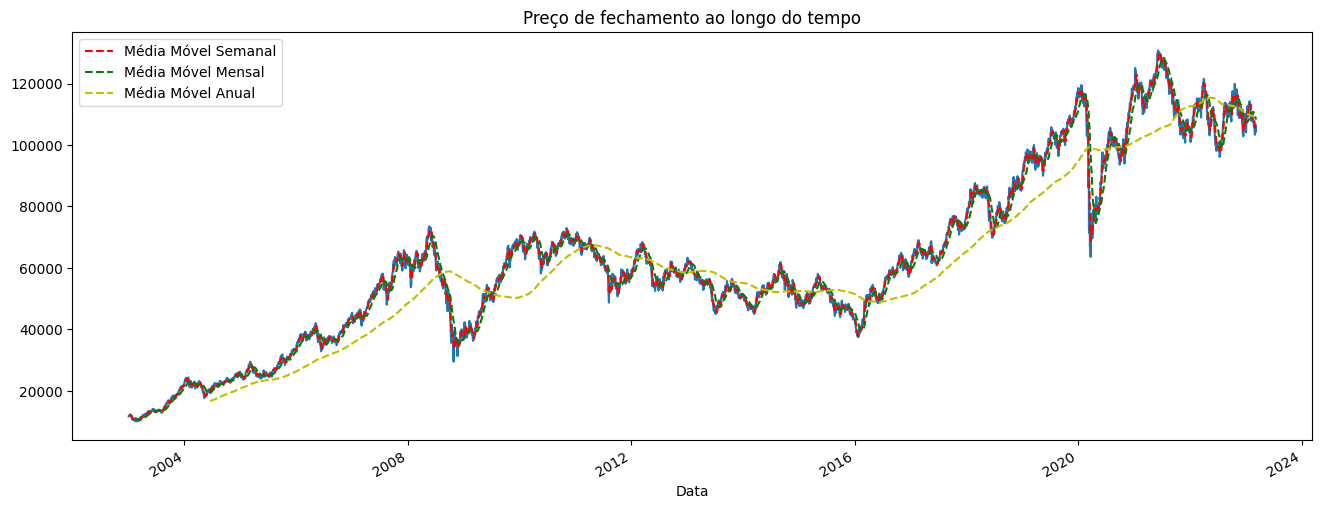

In [24]:
#Plotar a série temporal para analisar o comportamento ao longo do tempo
plt.figure(figsize = (16, 6))
df['Último'].plot()
df['Último'].rolling(7).mean().plot(color='r', style='--', label='Média Móvel Semanal', legend=True)
df['Último'].rolling(30).mean().plot(color='g', style='--', label='Média Móvel Mensal', legend=True)
df['Último'].rolling(365).mean().plot(color='y', style='--', label='Média Móvel Anual', legend=True)
plt.title("Preço de fechamento ao longo do tempo")
plt.show()

#### Decomposição da série: Tendência, Sazonalidade e resíduo

<Figure size 1600x600 with 0 Axes>

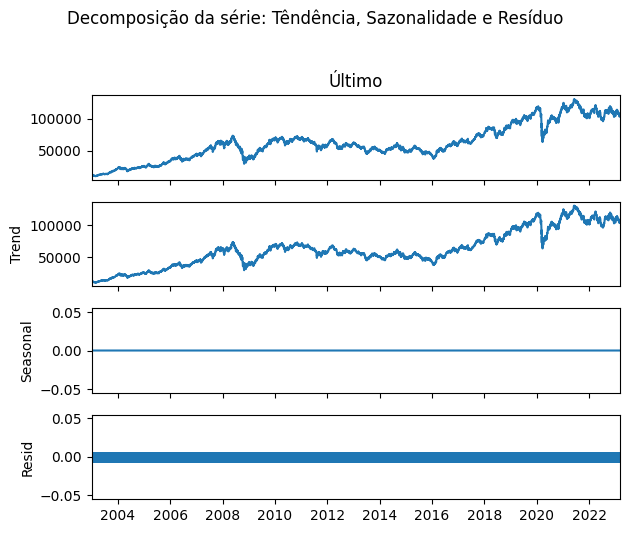

In [25]:
decomposition = sm.tsa.seasonal_decompose(df["Último"], model = 'additive',period=1)
plt.figure(figsize = (16, 6))
fig= decomposition.plot( ).suptitle('Decomposição da série: Têndência, Sazonalidade e Resíduo',y=1.1)
plt.show()

#### Estacionariedade

> ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not. The null and alternate hypothesis of this test are:
>
> - Null Hypothesis: The series has a unit root.
> - Alternate Hypothesis: The series has no unit root.
>
> If the null hypothesis in failed to be rejected, this test may provide evidence that the series is non-stationary.

Fonte: https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

In [26]:
def adf_test(timeseries):
    print("Resultados do teste ADF\n")
    result = adfuller(timeseries)
    print(f"Teste Estatístico: {result[0]}")
    print(f"P-Value: {result[1]}")

    print("\nValores críticos:")
    for key, value in result[4].items():
        print("\t- %s:\t%s" % (key, value))

    print()
    if result[1] < 0.05:
      print('Hipótese nula rejeitada, portanto a série é estacionária.')
    else:
      print('A hipótese nula não foi rejeitada, portanto a série é não estacionária.')


In [27]:
adf_test(df['Último'])

Resultados do teste ADF

Teste Estatístico: -1.5832810982310113
P-Value: 0.4919863031170957

Valores críticos:
	- 1%:	-3.43166168173001
	- 5%:	-2.8621196211801374
	- 10%:	-2.5670785331097763

A hipótese nula não foi rejeitada, portanto a série é não estacionária.


#### Autocorrelação e Autocorrelação Parcial

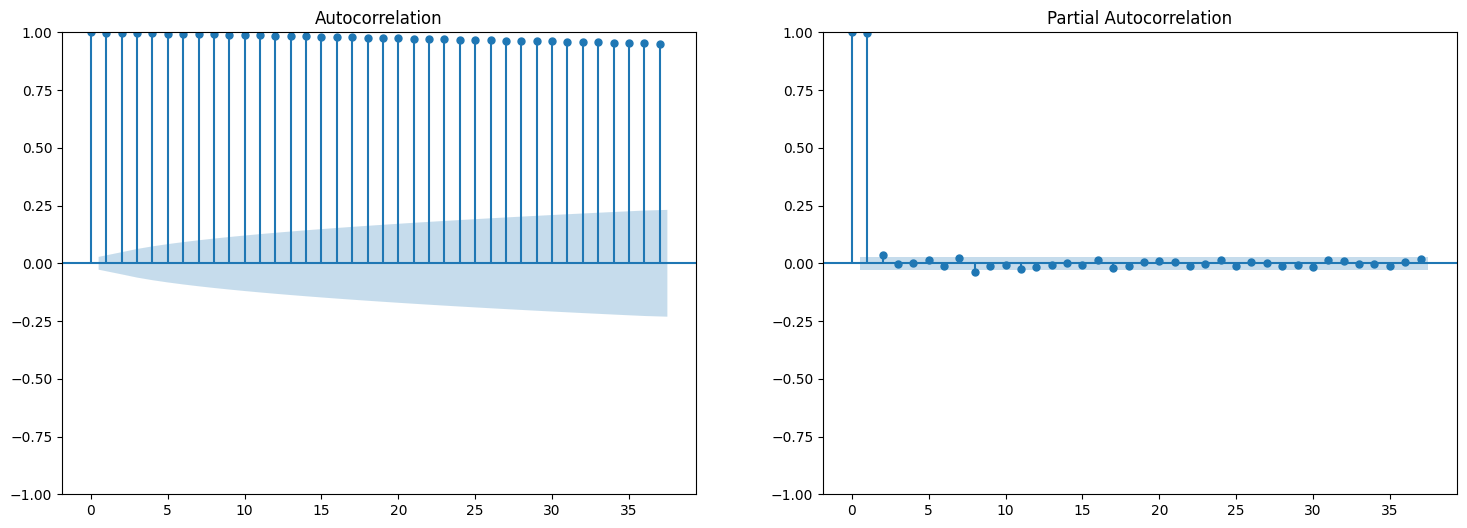

In [28]:
_, axes = plt.subplots(1, 2, figsize=(18,6))

plot_acf(df['Último'], ax=axes[0])
plot_pacf(df['Último'], ax=axes[1])
plt.show()

## Modelo Preditivo

##Escolhendo os modelos preditivos

Com base nos resultados da analise explorátoria dos dados a equipe selecionou os seguintes modelos para serem testados:

*   Prophet: é recomendado para previsão de dados de séries temporais com base em um modelo aditivo onde tendências não lineares são ajustadas à sazonalidade anual, semanal e diária. O Prophet é robusto em relação à falta de dados e às mudanças na tendência e normalmente lida bem com valores discrepantes.Além de fornecer uma previsão automatizada que poderá ser ajustada manualmente, caso necessário [(Fonte)](https://https://facebook.github.io/prophet/). O q

*   SARIMA: é uma extensão do ARIMA que suporta a modelagem direta do componente sazonal da série.O fato é que no ARIMA é espera dados que não sejam sazonais ou que tenham o componente sazonal removido, por exemplo, ajustados sazonalmente através de métodos como a diferenciação sazonal[(Fonte)](https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/)







###Prophet

O Prophet é um modelo de regressão aditiva com uma parte linear ou curva de tendência de crescimento logístico. Este modelo possuim um componente sazonal anual modelado usando série Fourier e um componente sazonal semanal modelado usando variáveis fictícias.
Desta forma, iremos avaliar a acuracidade deste modelo para a previsão de séries temporais.

Fonte:
https://docs.aws.amazon.com/pt_br/forecast/latest/dg/aws-forecast-recipe-prophet.html



####Conhecendo modelo

####Importação de bibliotecas

In [29]:
#instalando a biblioteca do Prophet
!pip install prophet
from prophet import Prophet

In [30]:
#importando as bibliotecas que serão utilizadas


Nesta etapa  iremos  preparar nossos dados para aplicar a previsão  utilizando Prophet. O Prophet espera receber um dataframe com duas colunas. A primeira coluna deve-se chamar DS e contem das das da série temporal. A segunda coluna deve-se chama Y e conter os valores a serem previstos.



In [31]:
#  Criação de um  data frame padrão
df_prophet = df.copy()
df_prophet= df_prophet.drop(columns=["Abertura","Máxima", "Vol.", "Var%", "Mínima","class_num","class_name"])

# verificando as primeiras 5 linhas
df_prophet.head()


,Último
Data,
2003-01-02,11603
2003-01-03,11600
2003-01-06,12020
2003-01-07,11876
2003-01-08,11786


In [32]:
# renomeando as colunas
df_prophet.index.rename('ds', inplace=True)
df_prophet = df_prophet.rename(columns={'Último': 'y'})
df_prophet['ds'] = df.index
df_prophet.head()

,y,ds
ds,,
2003-01-02,11603,2003-01-02
2003-01-03,11600,2003-01-03
2003-01-06,12020,2003-01-06
2003-01-07,11876,2003-01-07
2003-01-08,11786,2003-01-08


Similar ao procedimento que utilizamos para a biblioteca scikit-learn sklearn, deveremos criar uma instância do modelo e posteriormente realizar o treinamento (fit) do modelo.:

In [33]:
# instanciando o modelo
m = Prophet(yearly_seasonality=True)

# realizando o treinamento
m.fit(df_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5gra31rv/n_91hrfs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5gra31rv/p0wnv86z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32143', 'data', 'file=/tmp/tmp5gra31rv/n_91hrfs.json', 'init=/tmp/tmp5gra31rv/p0wnv86z.json', 'output', 'file=/tmp/tmp5gra31rv/prophet_modeli_xcd54k/prophet_model-20230903003901.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:39:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:39:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Agora iremos definir o período no qual queremos que  modelo faça a previsão. Para isso o Prophet disponibiliza um dataframe adequado que se estende para o futuro pelo número especifico de dias que queremos prever.  Podemos fazer istp através do  método  ***make_future_dataframe***.

In [34]:
# método auxiliar para previsão
future = m.make_future_dataframe(periods = 365)
# previsão do modelo
forecast = m.predict(future)

Dataframe de resultados do treinamento

No Dataframe gerado a coluna yhat representa as previsões. Já as colunas  yhat_lower e yhat_upper são as componentes do intervalo de incertezas.  Desta foma, uanto mais distante o tempo à frente, mais incerto fica a previsão.



In [35]:
# verificando as primeiras 5 linhas
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2003-01-02,11798.384399,4519.026929,19619.077100
1,2003-01-03,11903.059698,4177.528496,19188.489625
2,2003-01-06,12143.060157,4734.383511,19415.195882
3,2003-01-07,12252.054542,4729.667273,19556.649007
4,2003-01-08,12360.365197,4897.991757,19898.282873


Agora vamos treinar o modelo para conseguir analisar os resultados. Como essa é apenas uma validação do modelo, ainda não iremos nos preocupar en dividir a base de dados para treinamento e teste. Isto será realizado em etapas futuras.

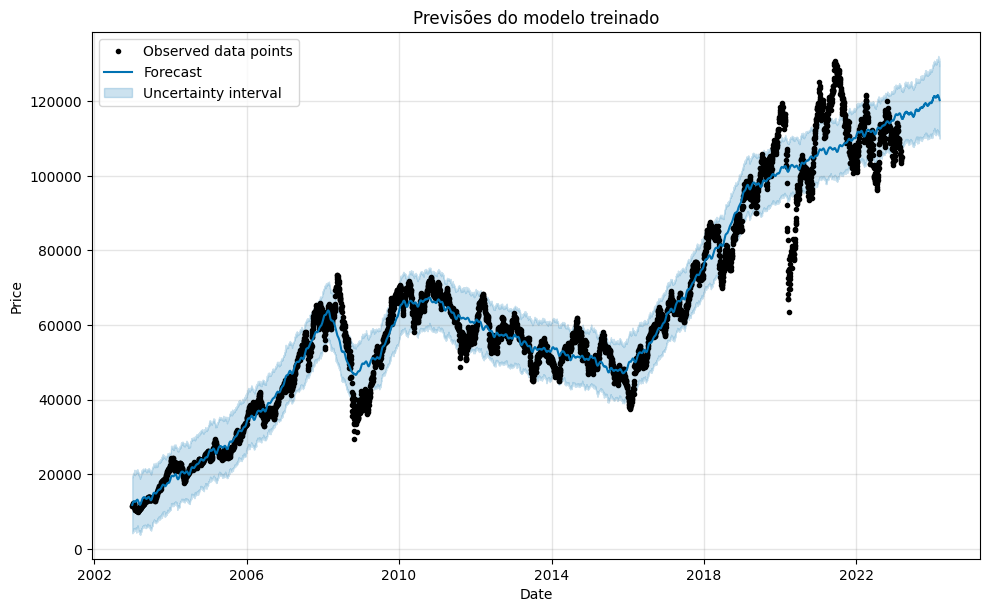

In [36]:
# previsões do modelo treinado
figure = m.plot(forecast, xlabel = 'Date', ylabel = 'Price')
plt.title("Previsões do modelo treinado")
plt.legend()

Podemos visualizar também os componentes da previsão de forma independente:

*   Trend (tendência)
*   yearly seasonality(sazonalidade anual)
*   Weekly seasonality(sazonalidade semanal)

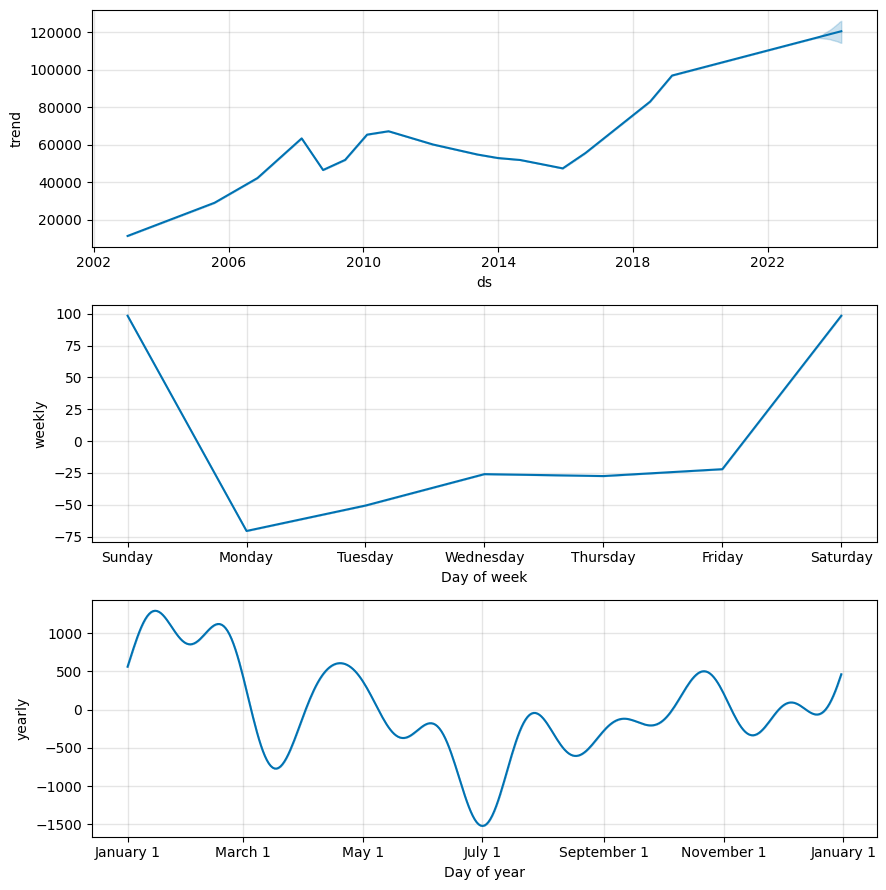

In [37]:
# verificando os componentes
figure2 = m.plot_components(forecast)

Agora que já conhecemos o modelos e identificamos e as previsões realizadas em nossa base de dados estão próximos dos nossos imputs reais. Iremos iniciar a construção do nosso modelo de previsão.

####Preparação os dados

Nesta próxima etapa iremos separar os dados que serão utilizados para teste e para treinamento.

In [38]:
# definindo uma data de corte
data_fim = '2022-08-20'
# definindo os dados de treino, antes da data de corte
train = df_prophet.loc[df_prophet['ds'] <= data_fim]
# definindo os dados de teste posterior a data de corte
test = df_prophet.loc[df_prophet['ds'] > data_fim]

In [39]:
# contando a quantidade de dias à frente para posteriormente checarmos a acurácia da previsão
dias_a_prever = len(test.ds.unique())
# checando a quantidade de dias
dias_a_prever

137

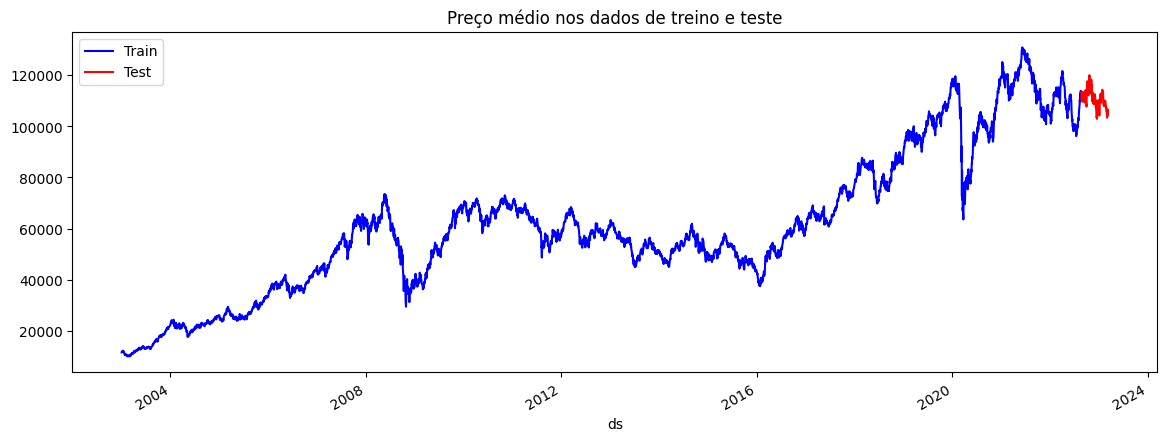

In [40]:
# definindo o tamanho do plot
f, ax = plt.subplots(figsize=(14,5))
# plotando os dados de treino
train.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
# plotando os dados de teste
test.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
# definindo o título
plt.title('Preço médio nos dados de treino e teste');

In [41]:
# criando a função MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)*100
    return np.mean(np.abs((y_true - y_pred) / y_true))

####Treinamento do Modelo

In [42]:
# instanciando o modelo
m = Prophet(yearly_seasonality=True)
# realizando o treinamento
#m = Prophet(changepoint_prior_scale=0.01)
m.fit(train)
# método auxiliar para previsão
future = m.make_future_dataframe(periods=dias_a_prever)
# previsão do modelo
forecast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5gra31rv/h8qe27oa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5gra31rv/jm11nwya.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15147', 'data', 'file=/tmp/tmp5gra31rv/h8qe27oa.json', 'init=/tmp/tmp5gra31rv/jm11nwya.json', 'output', 'file=/tmp/tmp5gra31rv/prophet_model7l8gtdyf/prophet_model-20230903003909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:39:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:39:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Dataframe de resultados do treinamento

In [43]:
# olhando os resultados das previsões com os dados de treino
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4995,2022-12-30,121576.260964,113743.659762,130102.296620
4996,2022-12-31,121930.957528,113642.109790,129823.660413
4997,2023-01-01,122023.818580,113739.567620,129954.645619
4998,2023-01-02,121818.888456,114056.424753,129981.842475
4999,2023-01-03,121918.915912,114248.790972,130640.236865


#####Componentes de sazonalidade e tendência

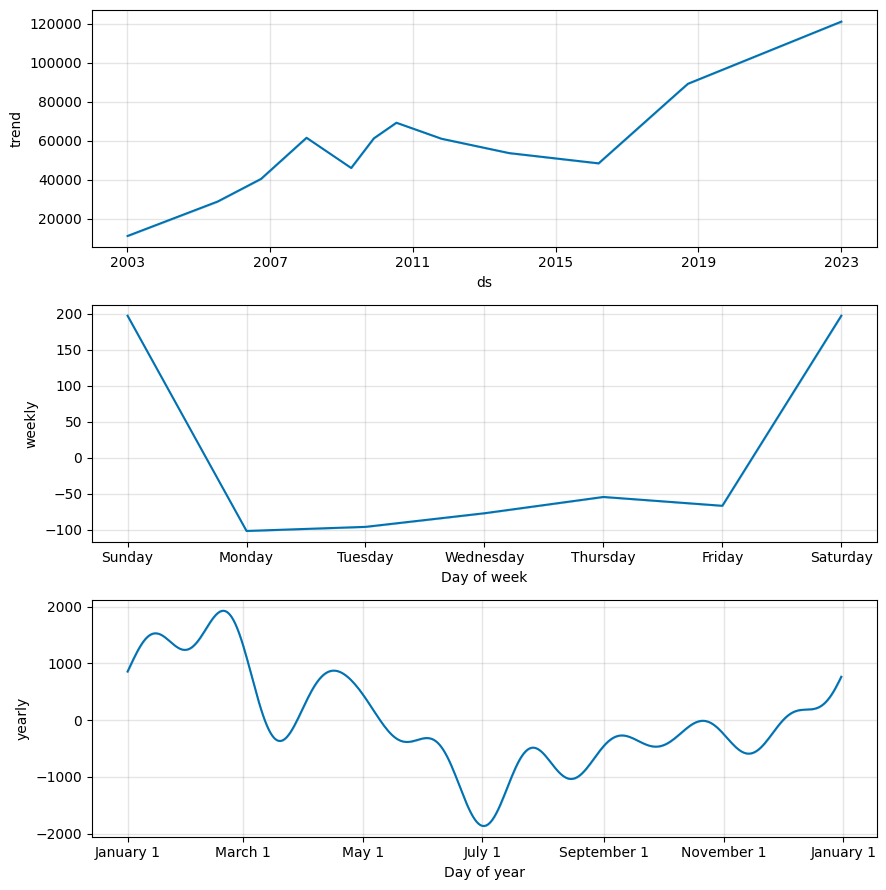

In [44]:
# Plotando os componentes
figure2 = m.plot_components(forecast)

#####Gráfico de previsão com dados de treino

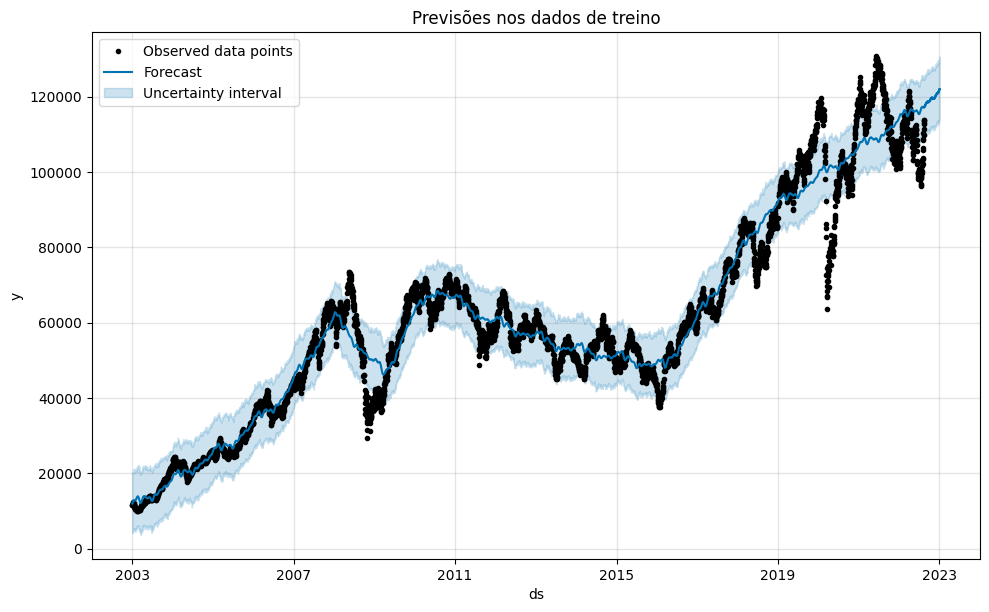

In [45]:
# configurando a área de plotagem
fig, ax = plt.subplots(1)
# alterando a altura
fig.set_figheight(6)
# alterando a largura
fig.set_figwidth(10)
# plotando o gráfico
fig = m.plot(forecast, ax=ax)
# definindo o título
plt.title('Previsões nos dados de treino');
plt.legend()

####Previsão

####Dataframe de resultados da previsão

In [46]:
# Previsões com os dados de teste
test_forecast = m.predict(test)
# Verificando os resultados das previsões com os dados de teste
test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
130,2023-03-01,123491.850797,115400.469451,131358.424858
131,2023-03-02,123421.064459,115418.395887,131140.102689
132,2023-03-03,123309.157482,115068.299759,132579.706798
133,2023-03-06,122953.883154,114321.292995,131400.618495
134,2023-03-07,122851.399938,114925.144688,131345.753683
135,2023-03-08,122764.308483,114479.758586,131474.852039
136,2023-03-09,122684.769110,114119.433912,131336.046797


#####Gráfico de previsão com dados de teste

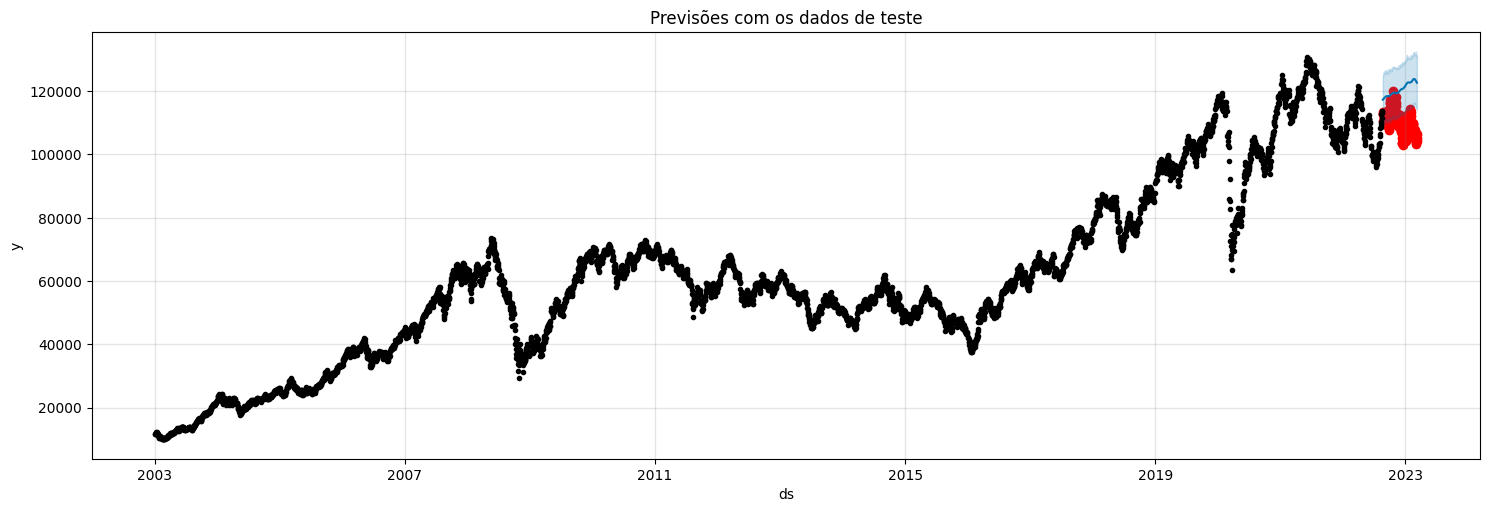

In [47]:
# configurando a área de plotagem
fig, ax = plt.subplots(1)
# alterando a altura
fig.set_figheight(5)
# alterando a largura
fig.set_figwidth(15)
# adicionando os dados de teste
ax.scatter(test.ds, test['y'], color='r')
# plotando o gráfico
fig = m.plot(test_forecast, ax=ax)
# definindo o título
plt.title('Previsões com os dados de teste');

#####Gráfico treinamento versus previsão

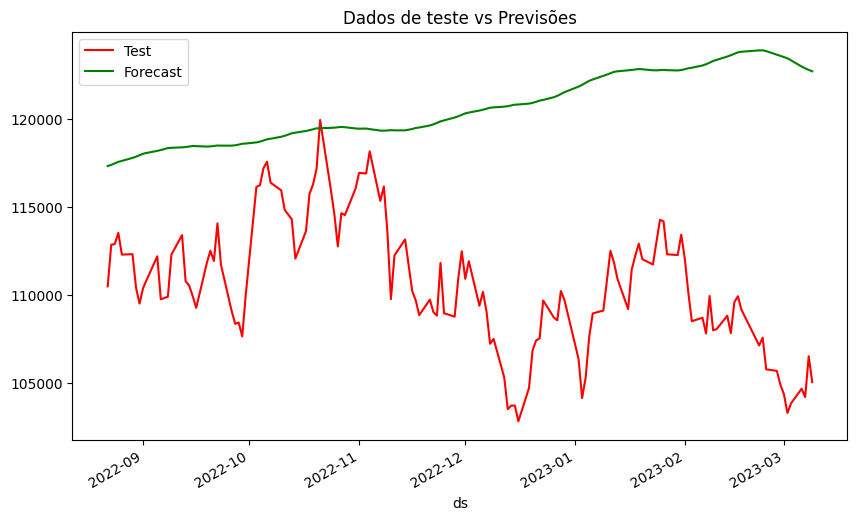

In [48]:
# configurando a área de plotagem
f, ax = plt.subplots(figsize=(14,5))
# alterando a altura
f.set_figheight(6)
# alterando a largura
f.set_figwidth(10)
# plotando o gráfico com dados de teste
test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
# plotando o gráfico com os dados previstos
test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
# definindo o título
plt.title('Dados de teste vs Previsões');

##### MAPE inicial

In [103]:
mape_prophet = mean_absolute_percentage_error(test['y'],test_forecast['yhat'])
print("MAPE",round(mape_prophet,3),"%")

KeyError: ignored

####Validação cruzada

A validação cruzada é uma técnica para avaliar a capacidade de generalização de um modelo, a partir de um conjunto de dados. Basicamente  a ténica consiste em dividir os dados em várias partições e treina vários algoritmos nessas partições.
Essa técnica melhora a robustez do modelo mantendo os dados do processo de treinamento. Além de melhorar o desempenho em observações não vistas, em ambientes com restrições de dados, pode ser uma ferramenta eficiente para treinar modelos com um conjunto de dados menor.
Fonte: https://learn.microsoft.com/pt-br/dotnet/machine-learning/how-to-guides/train-machine-learning-model-cross-validation-ml-net

#####Cenário

Nossa empresa deseja deseja um modelo capaz de prever os preços das ações diáriamente e planeja executar o modelo no início de cada semestres(180 dias). Inicialmente iremos testar a acuracidade do modelo com 2 anos de dados (730 dias) e  utilizar a validação cruzada para identificar o melhor horizonte de previsão para nosso modelo

Desta forma temos seguintes informações:

*   Horizonte= 1-365 dias
*   Periodo = 180 dias
*   Inicial= 730 dias

INFO:prophet:Making 34 forecasts with cutoffs between 2005-05-15 00:00:00 and 2021-08-19 00:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp5gra31rv/_xwdadtt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5gra31rv/yvjfjlnm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36762', 'data', 'file=/tmp/tmp5gra31rv/_xwdadtt.json', 'init=/tmp/tmp5gra31rv/yvjfjlnm.json', 'output', 'file=/tmp/tmp5gra31rv/prophet_model1s4hy047/prophet_model-20230903003921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:39:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:39:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5gra31rv/g3sdqlpd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5gra31rv/0glt3fpk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

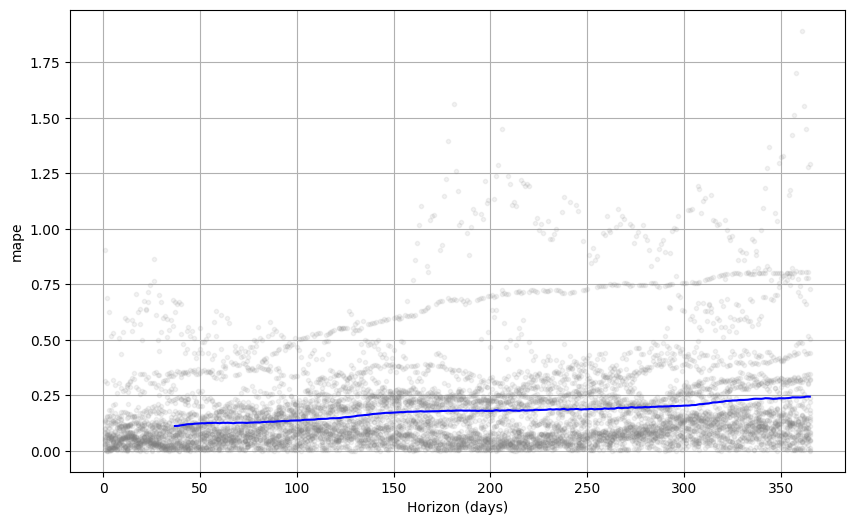

In [50]:
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')

fig = plot_cross_validation_metric(df_cv, metric='mape')

#####Dataframe de resultados da previsão

In [51]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,1.001327e+08,10006.635179,6651.656895,0.111433,0.064693,0.107962,0.421429
1,38 days,1.003817e+08,10019.068352,6670.516940,0.111681,0.064693,0.108262,0.419218
2,39 days,1.013328e+08,10066.420026,6726.569651,0.112476,0.065493,0.109062,0.414493
3,40 days,1.046583e+08,10230.262679,6844.414123,0.114397,0.066525,0.110934,0.411905
4,41 days,1.071597e+08,10351.798759,6939.457235,0.115620,0.067238,0.112280,0.407571


In [52]:
teste=df_p['mape']*100

In [53]:
teste

0      11.143257
1      11.168127
2      11.247615
3      11.439692
4      11.561975
         ...    
324    24.047556
325    24.143444
326    24.333734
327    24.400299
328    24.356939
Name: mape, Length: 329, dtype: float64

#####Gráfico MAPE Validação Cruzada

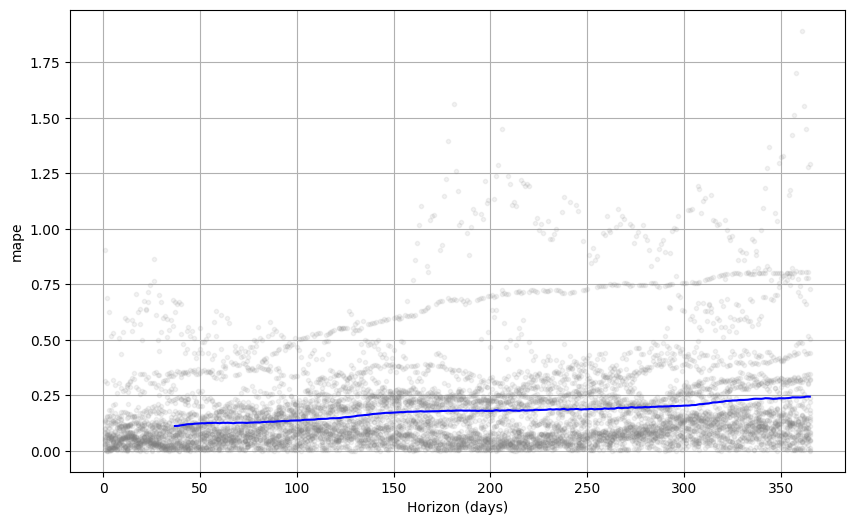

In [54]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [55]:
#Preparar datadrame de validação cruzada
maxValues = df_p["mape"].min()
mape_valid_cruzada = df_p[df_p['mape'] == maxValues]
mape_valid_cruzada= mape_valid_cruzada.drop(columns=["mse","rmse", "mae", "smape","coverage","mdape"])
mape_valid_cruzada["mape%"]= mape_valid_cruzada["mape"]*100

#####MAPE

In [56]:
mape_valid_cruzada

,horizon,mape,mape%
0,37 days,0.111433,11.143257


In [102]:
mape_prophet_cross= df_p['mape'].min()*100

###Prophet com série estacionária

"Uma série estacionária tem média constante durante o tempo, não existe tendências de alta ou de baixa. A razão disso é que tendo uma média constante com variações ao redor desta média fica muito mais fácil de extrapolar ao futuro."*texto em itálico*

 [Fonte](https://medium.com/ensina-ai/princ%C3%ADpios-b%C3%A1sicos-para-criar-previs%C3%B5es-de-s%C3%A9ries-temporais-e58c451a25b#:~:text=Normalmente%20s%C3%B3%20%C3%A9%20necess%C3%A1rio%20uma,mais%20do%20que%202%20diferencia%C3%A7%C3%B5es).

Desta forma, com intuito de buscar resultados mais interessantes para o modelo que será entregue, a equipe decidiu testar o modelo Prophet novamente mas utilizando uma série estacionária.

#### Transformação da série da série em estacionária

Conforme analisado anteriormente, nossa série não é estacionária. Desta formam iremos utilizar a técnica de diferenciação para transformação da série.

"A diferenciação é uma técnica utilizada para remover os sinais de tendências e reduzir a variância Para isso  é calculado a diferença do valor do período T com o valor do período anterior T-1."

 [Fonte](https://medium.com/ensina-ai/princ%C3%ADpios-b%C3%A1sicos-para-criar-previs%C3%B5es-de-s%C3%A9ries-temporais-e58c451a25b#:~:text=Normalmente%20s%C3%B3%20%C3%A9%20necess%C3%A1rio%20uma,mais%20do%20que%202%20diferencia%C3%A7%C3%B5es).


##### Gráfico primeira diferenciação

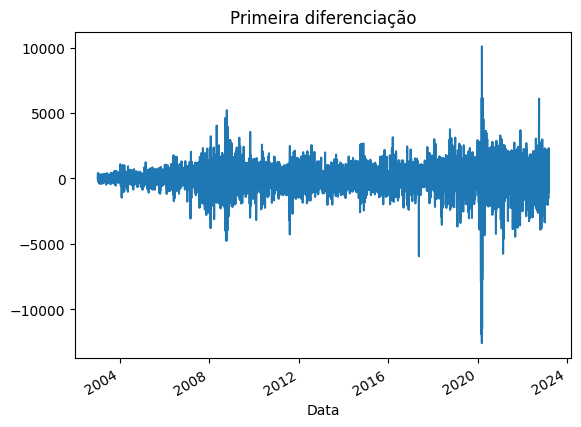

In [58]:
#Aplicar diferenciação
df_estacionaria = df['Último'].diff()
df_estacionaria = df_estacionaria.dropna()
plt.title("Primeira diferenciação")
df_estacionaria.plot()
plt.show()

##### Resultado teste ADF

In [59]:
#verificar se série transformou em estacionária

adf_test(df_estacionaria)

Resultados do teste ADF

Teste Estatístico: -19.390402176209314
P-Value: 0.0

Valores críticos:
	- 1%:	-3.43166168173001
	- 5%:	-2.8621196211801374
	- 10%:	-2.5670785331097763

Hipótese nula rejeitada, portanto a série é estacionária.


##### Gráfico comparativo

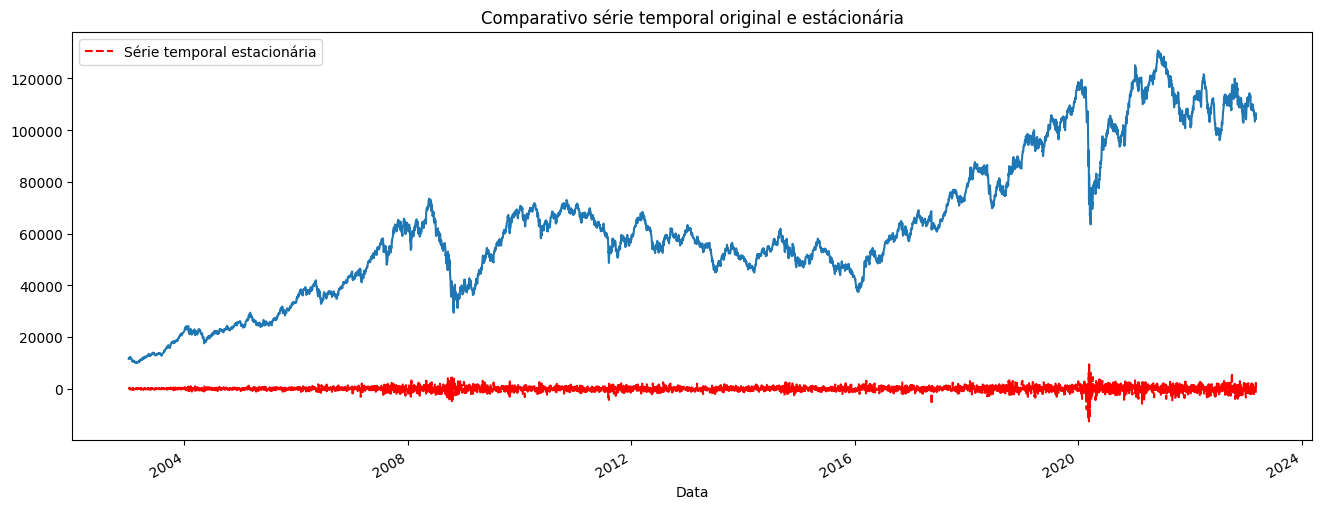

In [60]:
#Plotar a série temporal para analisar o resultado da transformação da série em estacionária
plt.figure(figsize = (16, 6))
df['Último'].plot()
df_estacionaria.plot(color='r', style='--', label='Série temporal estacionária', legend=True)
plt.title("Comparativo série temporal original e estácionária")
plt.show()

Preparação dos dados

Nesta etapa  iremos  preparar nossos dados para aplicar a previsão  utilizando Prophet. O Prophet espera receber um dataframe com duas colunas. A primeira coluna deve-se chamar DS e contem das das da série temporal. A segunda coluna deve-se chama Y e conter os valores a serem previstos.


In [61]:
#  Criação de um  data frame padrão
df_prophet= df_estacionaria.to_frame(name='y')

# verificando as primeiras 5 linhas
df_prophet.head()

# renomeando as colunas
df_prophet.head()
df_prophet.reset_index(inplace=True)

df_prophet= df_prophet.rename(columns={'Data': 'ds'})
df_prophet.head()


,ds,y
0,2003-01-03,-3.0
1,2003-01-06,420.0
2,2003-01-07,-144.0
3,2003-01-08,-90.0
4,2003-01-09,126.0


In [62]:
# definindo uma data de corte
data_fim = '2022-08-20'
# definindo os dados de treino, antes da data de corte
train = df_prophet.loc[df_prophet['ds'] <= data_fim]
# definindo os dados de teste posterior a data de corte
test = df_prophet.loc[df_prophet['ds'] > data_fim]

In [63]:
# contando a quantidade de dias à frente para posteriormente checarmos a acurácia da previsão
dias_a_prever = len(test.ds.unique())
# checando a quantidade de dias
dias_a_prever

137

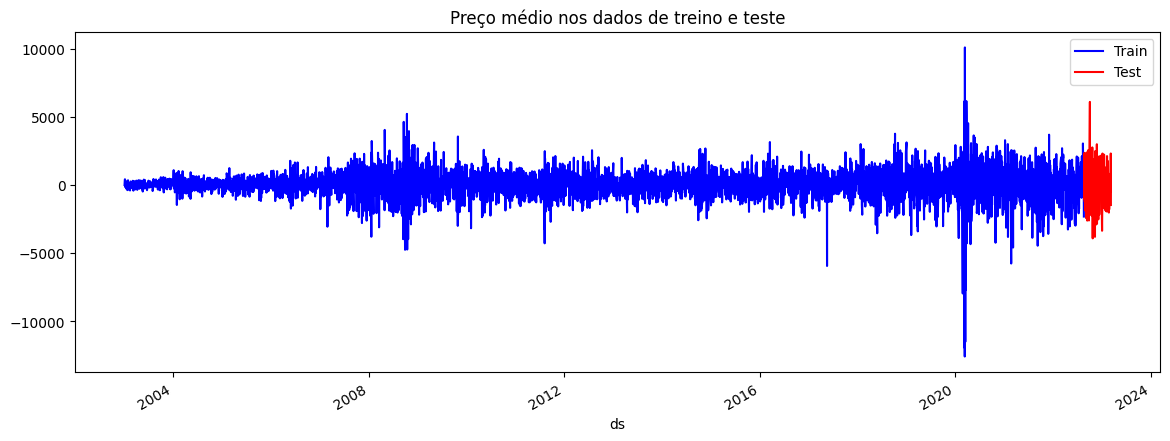

In [64]:
# definindo o tamanho do plot
f, ax = plt.subplots(figsize=(14,5))
# plotando os dados de treino
train.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
# plotando os dados de teste
test.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
# definindo o título
plt.title('Preço médio nos dados de treino e teste');

####Treinamento do modelo

In [65]:
# instanciando o modelo
m = Prophet(yearly_seasonality=True)
# realizando o treinamento
#m = Prophet(changepoint_prior_scale=0.01)
m.fit(train)
# método auxiliar para previsão
future = m.make_future_dataframe(periods=dias_a_prever)
# previsão do modelo
forecast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5gra31rv/9gq52i3t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5gra31rv/tsesskn2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89430', 'data', 'file=/tmp/tmp5gra31rv/9gq52i3t.json', 'init=/tmp/tmp5gra31rv/tsesskn2.json', 'output', 'file=/tmp/tmp5gra31rv/prophet_model5xcwcu5x/prophet_model-20230903004043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:40:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:40:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [66]:
# olhando os resultados das previsões com os dados de treino
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4994,2022-12-30,152.157427,-1312.892848,1459.730997
4995,2022-12-31,142.460317,-1186.385744,1537.795302
4996,2023-01-01,143.417058,-1153.339397,1480.425830
4997,2023-01-02,111.984807,-1233.534786,1548.631542
4998,2023-01-03,217.510841,-1146.045623,1621.073157


#####Componentes de sazonalidade e tendência

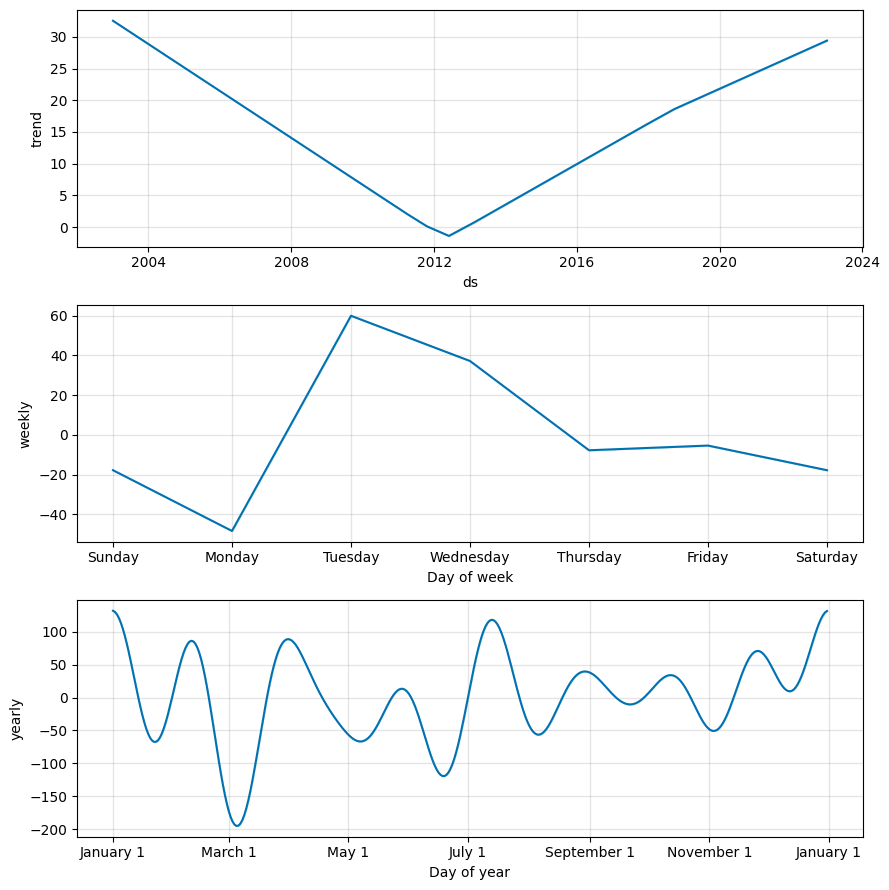

In [67]:
# Plotando os componentes
figure2 = m.plot_components(forecast)

#####Gráfico de previsão com dados de treino

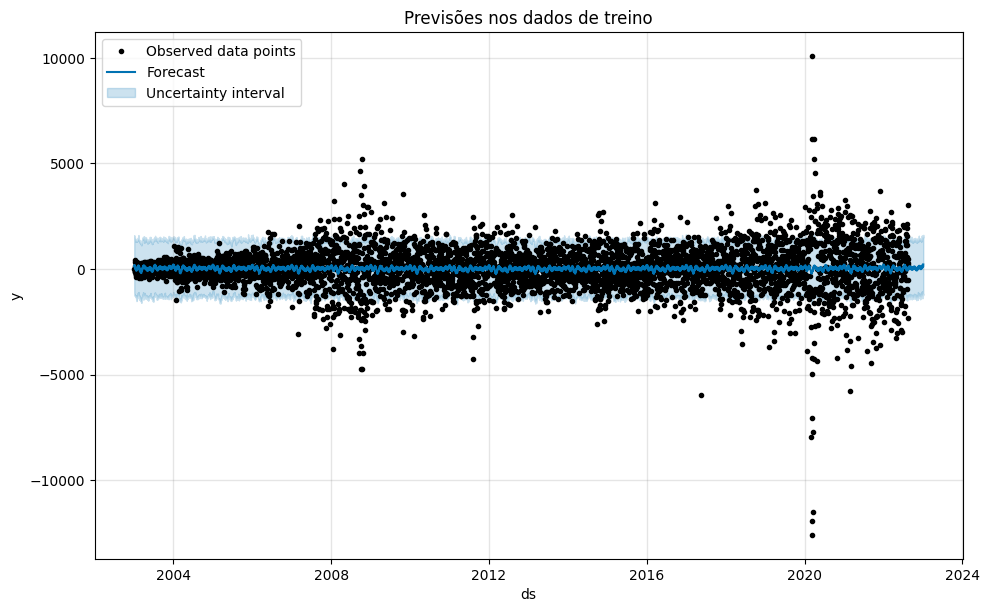

In [68]:
# configurando a área de plotagem
fig, ax = plt.subplots(1)
# alterando a altura
fig.set_figheight(6)
# alterando a largura
fig.set_figwidth(10)
# plotando o gráfico
fig = m.plot(forecast, ax=ax)
# definindo o título
plt.title('Previsões nos dados de treino');
plt.legend()

####Previsão

####Dataframe de resultados da previsão

In [69]:
# Previsões com os dados de teste
test_forecast = m.predict(test)
# Verificando os resultados das previsões com os dados de teste
test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
130,2023-03-01,-99.738828,-1460.469667,1275.274068
131,2023-03-02,-155.086523,-1547.164102,1230.406034
132,2023-03-03,-160.876956,-1532.583599,1078.795456
133,2023-03-06,-213.397060,-1417.886494,1134.376953
134,2023-03-07,-103.244845,-1478.020278,1232.390439
135,2023-03-08,-121.616016,-1447.176115,1138.545939
136,2023-03-09,-159.772558,-1508.755448,1210.475066


#####Gráfico de previsão com dados de teste

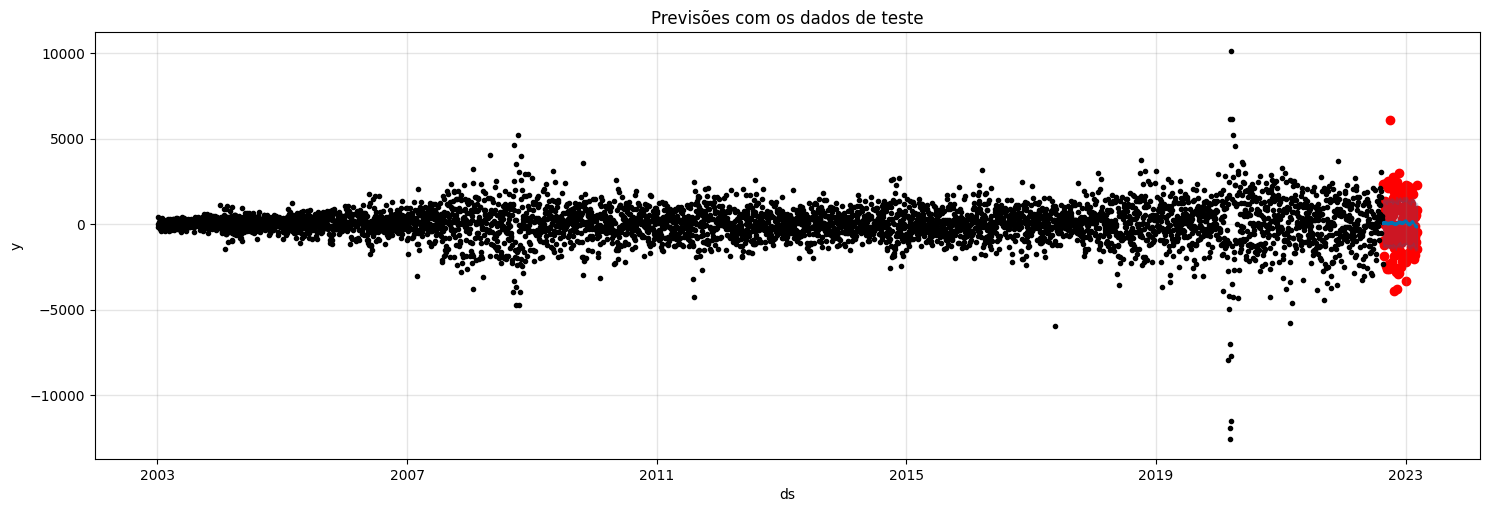

In [70]:
# configurando a área de plotagem
fig, ax = plt.subplots(1)
# alterando a altura
fig.set_figheight(5)
# alterando a largura
fig.set_figwidth(15)
# adicionando os dados de teste
ax.scatter(test.ds, test['y'], color='r')
# plotando o gráfico
fig = m.plot(test_forecast, ax=ax)
# definindo o título
plt.title('Previsões com os dados de teste');

#####Gráfico treinamento versus previsão

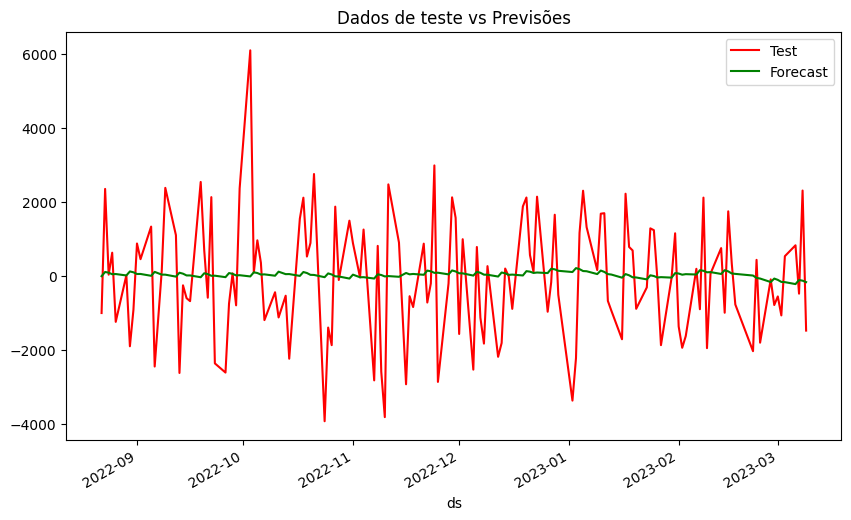

In [71]:
# configurando a área de plotagem
f, ax = plt.subplots(figsize=(14,5))
# alterando a altura
f.set_figheight(6)
# alterando a largura
f.set_figwidth(10)
# plotando o gráfico com dados de teste
test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
# plotando o gráfico com os dados previstos
test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
# definindo o título
plt.title('Dados de teste vs Previsões');

##### MAPE

In [72]:
mape_prophet_stationary = mean_absolute_percentage_error(test['y'],test_forecast['yhat'])
print("MAPE",round(mape_prophet_stationary,3),"%")

MAPE 20.242 %


###SARIMA

####Importação de bibliotecas

In [73]:
import warnings
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt

####Selecionar de Parâmetros para o Modelo

Na construção de modelo Arima Sazonal é necessário encontrar os valores de ARIMA(p,d,q) que otimizem os resultados do modelo. Para obter essas informações decidimos realizar uma pesquisa em grade, na qual iremos testar os diversos parametros e selecionar o que obter os melhores métricas AIC através da função SARIMAX.


In [74]:
# # Definir os parâmetros p, d e q para assumir qualquer valor entre 0 e 2
p = d = q = range(0, 2)


In [75]:
#  Gerar diferente combinaçãoes p, d, q
pdq = list(itertools.product(p, d, q))


In [76]:
# Gerar diferentes combinação p, d, q, s
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [77]:

print('Exemplo de combinações de parametros')
print('SARIMAX: {} {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} {}'.format(pdq[1], seasonal_pdq[3]))
print('SARIMAX: {} {}'.format(pdq[1], seasonal_pdq[4]))


Exemplo de combinações de parametros
SARIMAX: (0, 0, 1) (0, 0, 1, 12)
SARIMAX: (0, 0, 1) (0, 1, 0, 12)
SARIMAX: (0, 0, 1) (0, 1, 1, 12)
SARIMAX: (0, 0, 1) (1, 0, 0, 12)


In [78]:
# Verificar parametros com melhores AIC's
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_estacionaria,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:83969.98964601236
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:83781.93593866438
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:87243.29909589374
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:83774.3923279511
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:83797.7226095371
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:83783.96306917706
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:85599.10315112567
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:83775.36775282049
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:83927.63154369575
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:83739.68449290821
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:87196.99518820876
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:83600.06869972647
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:83771.39749077117
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:83741.69810019297
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:85585.18112827302
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:83601.98193444917
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:87787.33101728138
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:87590.03163844273
ARIMA(0, 1, 

In [79]:
#ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:83738.69063242625


####Separar dados para treinamento e teste

In [80]:
train=df.iloc[:365]
test=df.iloc[365:]

Treinar o modelo o modelo

In [81]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model=SARIMAX(train["Último"],order=(1,0,1),seasonal_order=(0,0,1,12))
results=model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             Último   No. Observations:                  365
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 12)   Log Likelihood               -2627.800
Date:                            Sun, 03 Sep 2023   AIC                           5263.601
Time:                                    00:46:56   BIC                           5279.200
Sample:                                         0   HQIC                          5269.800
                                            - 365                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998      0.001   1460.821      0.000       0.998       1.001
ma.L1          0.0910      0.041      2.208      0.027       0.010       0.172
ma.S.L12       0.0294      0.042      0.706      0.480      -0.052       0.111
sigma2      1.034e+05   5650.104     18.308      0.000    9.24e+04    1.15e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                64.87
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               5.34   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

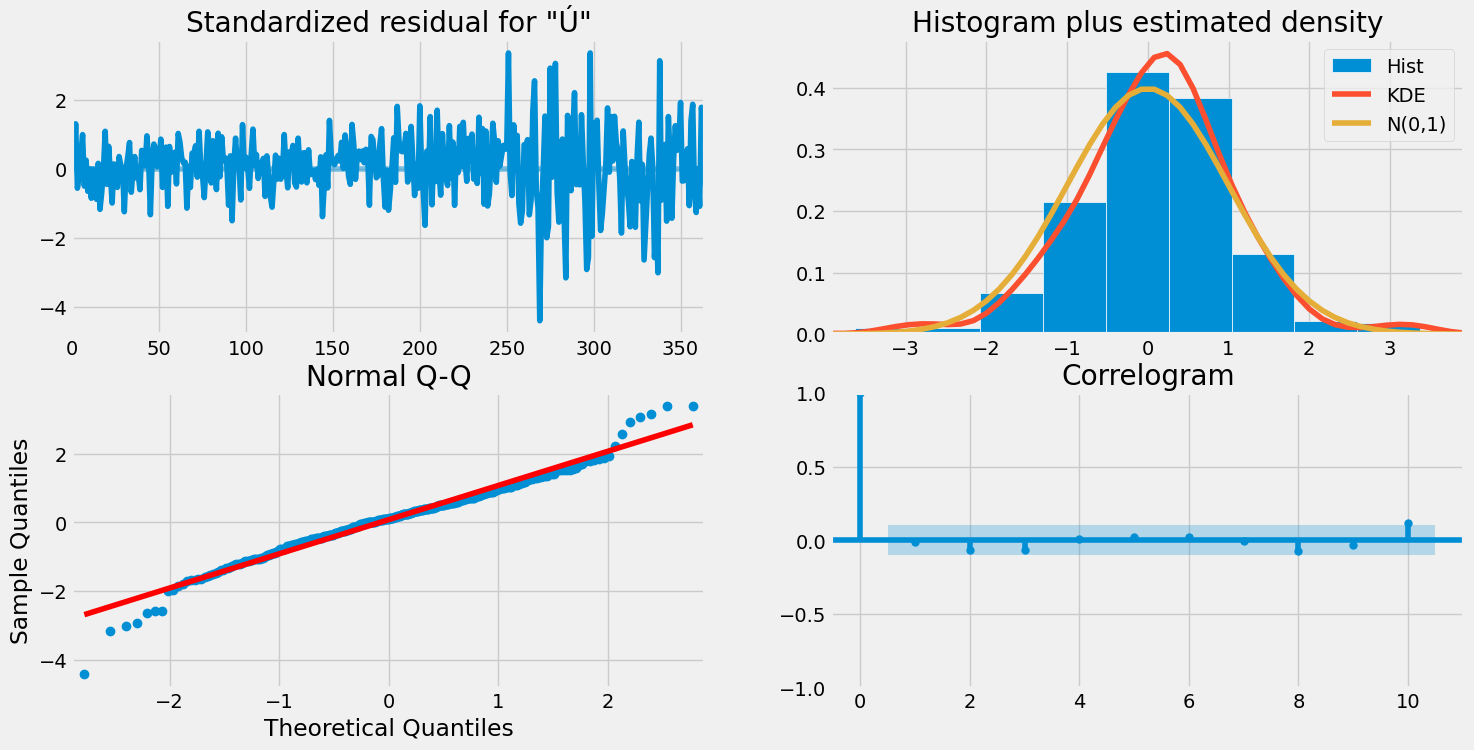

In [82]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

####Previsão

In [83]:
start=len(train)
end=len(train)+len(test)-1

predictions_SARIMA=results.predict(start, end,type='levels').rename('SARIMA Predcitions')


####MAPE

In [84]:
mape_sarima = mean_absolute_percentage_error(test['Último'],predictions_SARIMA)
print("MAPE",round(mape_sarima,3),"%")

MAPE 23.703 %


### AutoARIMA com Média Móvel

In [85]:
!pip install statsforecast=="1.5.0"
from statsforecast import StatsForecast
from statsforecast.models import Naive, AutoARIMA

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.0/275.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.6/154.6 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.6/299.6 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.2/185.2 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 20.4 MB/s eta

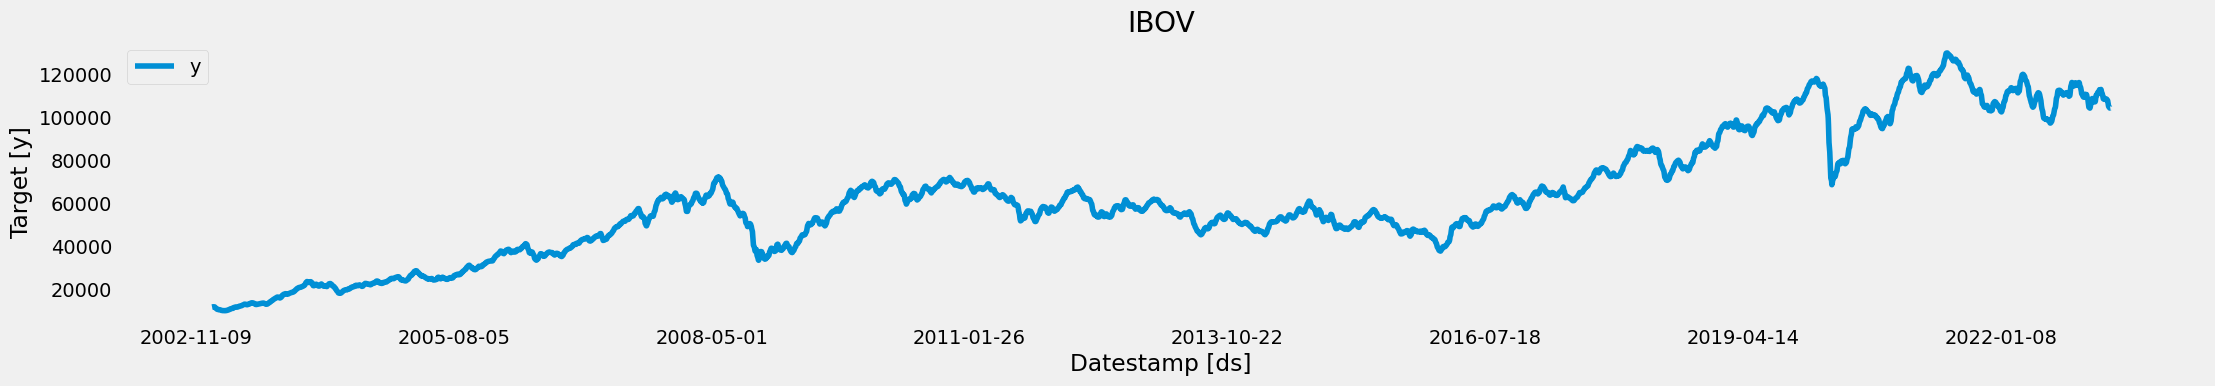

In [86]:
df_statsforecast = df[['Último']].copy()
# df_statsforecast = df_statsforecast.resample('1D').interpolate()
df_statsforecast['unique_id'] = 'IBOV'
df_statsforecast = df_statsforecast.reset_index()
df_statsforecast = df_statsforecast.rename(columns={'Último':'y', 'Data':'ds'})
df_statsforecast['y'] = df_statsforecast['y'].rolling(7).mean()
df_statsforecast = df_statsforecast.dropna()
StatsForecast.plot(df_statsforecast,engine ='matplotlib')

In [87]:
df_statsforecast.head(10)

,ds,y,unique_id
6,2003-01-10,11862.857143,IBOV
7,2003-01-13,11935.285714,IBOV
8,2003-01-14,12017.428571,IBOV
9,2003-01-15,12010.428571,IBOV
10,2003-01-16,12021.285714,IBOV
11,2003-01-17,12005.571429,IBOV
12,2003-01-20,11967.857143,IBOV
13,2003-01-21,11852.428571,IBOV
14,2003-01-22,11714.142857,IBOV
15,2003-01-23,11569.428571,IBOV


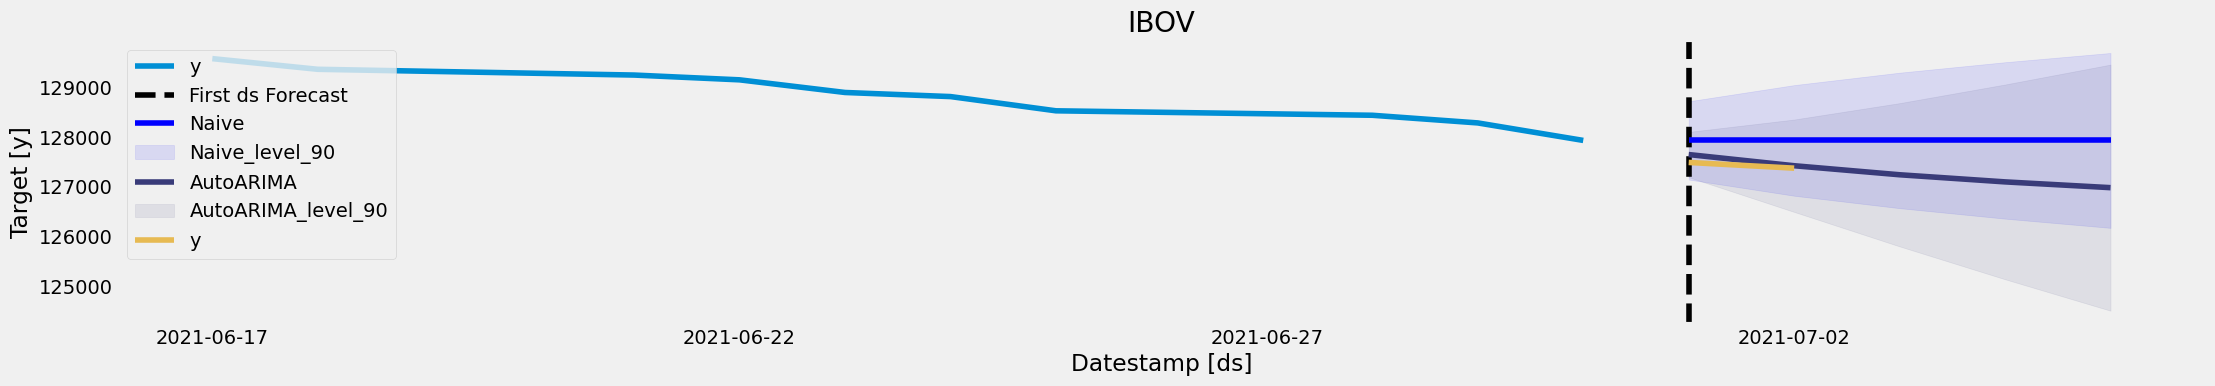

In [88]:
train_d=365
h=5
Y_df = df_statsforecast[(df_statsforecast['ds'] >= '2021-01-01') & (df_statsforecast['ds'] < '2021-07-01')].copy()
test_df = df_statsforecast[(df_statsforecast['ds'] >= '2021-07-01') & (df_statsforecast['ds'] < '2021-07-06')].copy()
# Y_df['y'] = Y_df['y'].diff()
# Y_df = Y_df.dropna()

sf = StatsForecast(
    # df=Y_df,
    models=[
      Naive(),
      AutoARIMA(season_length=1, trace=False)
    ],
    freq='D',
    n_jobs=-1
)
sf.fit(Y_df)
forecasts_df = sf.predict(h=h, level=[90])
forecasts_df = forecasts_df.reset_index().merge(test_df, on=['ds', 'unique_id'], how='left')
sf.plot(Y_df, forecasts_df, level=[90], max_insample_length=10,engine ='matplotlib', plot_random=False)

In [89]:
Y_df.dtypes

ds           datetime64[ns]
y                   float64
unique_id            object
dtype: object

In [90]:
forecasts_df.head()

,unique_id,ds,Naive,Naive-lo-90,Naive-hi-90,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,y
0,IBOV,2021-07-01,127931.859375,127145.250000,128718.468750,127647.343750,127191.664062,128103.015625,127488.857143
1,IBOV,2021-07-02,127931.859375,126819.421875,129044.296875,127422.796875,126493.664062,128351.929688,127373.714286
2,IBOV,2021-07-03,127931.859375,126569.414062,129294.304688,127241.062500,125800.445312,128681.679688,NaN
3,IBOV,2021-07-04,127931.859375,126358.640625,129505.078125,127097.765625,125139.281250,129056.250000,NaN
4,IBOV,2021-07-05,127931.859375,126172.945312,129690.773438,126981.679688,124506.906250,129456.445312,127003.142857


In [91]:
# h = 7
# teste = df_statsforecast[-h:] # Ultimos dias
# treino = df_statsforecast[:-h] # Todos os dados menos o de teste

# teste

In [92]:
# frequencia = 'B' # dias uteis
# season_length = 30
# modelos = [
#     Naive(),
#     SeasonalNaive(season_length=season_length),
#     # SeasonalWindowAverage(season_length=season_length, window_size=365),
#     # HistoricAverage(),
#     AutoARIMA(season_length=season_length),
#     AutoARIMA(season_length=season_length, d=1, alias='AutoARIMA_d')
# ]

# sf = StatsForecast(models=modelos, freq=frequencia, n_jobs=-1)

In [93]:
# sf.fit(treino)

In [94]:
crossvalidation_df = sf.cross_validation(
    df=df_statsforecast,
    h=h,
    step_size=14,
    n_windows=120
  )
crossvalidation_df

,ds,cutoff,y,Naive,AutoARIMA
unique_id,,,,,
IBOV,2018-08-12,2018-08-11,50199.714844,50481.429688,50435.597656
IBOV,2018-08-13,2018-08-11,49983.000000,50481.429688,50401.480469
IBOV,2018-08-14,2018-08-11,49829.285156,50481.429688,50379.363281
IBOV,2018-08-15,2018-08-11,49530.000000,50481.429688,50365.023438
IBOV,2018-08-16,2018-08-11,49417.285156,50481.429688,50355.730469
...,...,...,...,...,...
IBOV,2023-03-05,2023-03-04,105087.289062,105556.710938,104948.421875
IBOV,2023-03-06,2023-03-04,104674.000000,105556.710938,104518.218750
IBOV,2023-03-07,2023-03-04,104449.710938,105556.710938,104245.390625


<Axes: xlabel='ds'>

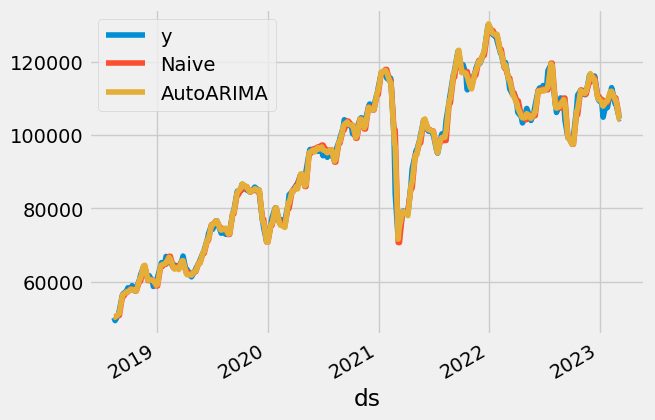

In [95]:
crossvalidation_df.groupby(['ds']).mean().plot()

In [96]:
!pip install -q datasetsforecast
from datasetsforecast.losses import mse, mae, rmse, mape

def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    for model in models:
        eval_ = df.groupby(['unique_id', 'cutoff']).apply(lambda x: metric(x['y'].values, x[model].values)).to_frame() # Calculate loss for every unique_id, model and cutoff.
        eval_.columns = [model]
        evals.append(eval_)
    evals = pd.concat(evals, axis=1)
    evals = evals.groupby(['unique_id']).mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

In [97]:
evaluation_df = evaluate_cross_validation(crossvalidation_df, mape)
evaluation_df.head()

,Naive,AutoARIMA,best_model
unique_id,,,
IBOV,1.175969,0.803927,AutoARIMA


In [98]:
mape_AutoARIMA = evaluation_df.loc['IBOV']['AutoARIMA']
mape_AutoARIMA

0.8039265132780807

#RESUMO DOS RESULTADOS

In [99]:
data = [
    ['Prophet modelo inicial', mape_prophet],
    ['Prophet com validação cruzada', mape_prophet_cross],
    ['Prophet com série estacionária', mape_prophet_stationary],
    ['SARIMA', mape_sarima],
    ['AutoARIMA com Média Móvel', mape_AutoARIMA]
]

resultado_final = pd.DataFrame(data, columns=['Modelo', 'MAPE%'])
resultado_final